<a href="https://colab.research.google.com/github/drscook/REU_2019/blob/master/main_v18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v18
- removed out-of-date code
- escape times overlays
- Galton board

v17
- More major refactoring
- critical bug with partial walls squashed
- tiny particle radius problem fixed (I think)
- Cell classes
- 3D phase portraits
- Detection of "effective" bundaries from data
- escape time function
- Draw from upper hemisphere
- plotting from saved data

v16
- DOA

v15
- DOA

v14
- Major refactoring of code to make new features work better with older ones
- Done hurriedly and still not test as thoroughly as I would like

v13
- Galton Board

v12 (The Nicholas Update)
- run now has sister function run_with_conditions(part,Walls,conds)
- Defined Conditional types:
- ShiftAccumulator(thresh_func) checks cell shift to see if it surpasses a threshold.
- DistAccumulator(thresh_func) does the same thing for total distance (cell_shift+pos)
- StepMax is the "ordinary condition" to be used whenever more complex conditions aren't needed. (run still works as normal.)

v11
- spin arrows
- shadows for prior collisions
- improved, more efficient phase portraits
- record phase during simulation in the following order: [vel normal, vel tangential, spin]
- many general code improvements

v10
- no interpolate for draw with no force
- fix memory crash for phase portraits

v9
phase portraits

v8
- handles complex (corner) collisions by slightly redirecting particle to avoid them.  Add complexity to the logic in next_state, but should be invisible to the user.  Report any bugs.
- Made it easier to use colab widgets
- sped up render static trajectory plot

v7
- force

v6 improvements
- no slip collisions

Major improvements from v3 to v5
- handles false collisions more efficiently
- animations
- wrap walls
- better cleanup
- export to json - easy to write to file if desired

# Main Code

In [0]:
# base_path = 'C:/Users/scook/Google Drive/active/REU 2019/v17/'
base_path = '/content/'

In [0]:
#@title Cook's Core Code (double-click to open) { display-mode: "form" }

import os
from abc import ABC, abstractmethod
import json
from copy import deepcopy
from pprint import pprint
import itertools as it
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import datetime
import pytz
cst = pytz.timezone('US/Central')
tol = 1e-8


####################################################################################################
### Helpers ###
####################################################################################################


class MyEncoder(json.JSONEncoder):
    """
    Custom JSON Encoder to cast numpy object to base python
    """
    def default(self, z):
        if isinstance(z, np.ndarray):
            return z.tolist()
        elif isinstance(z, np.int64):
            return int(z)
        return super().default(z)

def timestamp():
    return datetime.datetime.now(cst).strftime('%Y-%m-%d_%H-%M-%S')

def mag(v):
    """
    Compute magnitude
    """
    return np.sqrt(v.T @ v)

def rotation_matrix(theta):
    """
    Return the rotation matrix to be applied on the RIGHT
    """
    return np.array([[np.cos(theta), np.sin(theta)],
                     [-np.sin(theta), np.cos(theta)]])

def listify(x):
    """
    Ensures x is a list
    """
    if isinstance(x, str):  #strings
        return [x]
    elif isinstance(x, dict):  # dict
        print("Can't listify dict")
        return x
    else:
        try:  # lists, sets, tuples
            return list(x)
        except:  # int, float, other
            return [x]

def draw_unif_signed(n=1):
    return (2*np.random.rand(n)-1).squeeze() # U[-1,1]
        
def draw_cosine(n=1):
    return  np.arcsin(draw_unif_signed(n)).squeeze()  # Follows the cosine law in [-pi/2,pi/2]


def draw_upper_hemisphere(n=1):
    phi = draw_cosine(n)
    theta = draw_unif_signed(n) * np.pi # U[-pi,pi]
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return np.array([x, y, z]).squeeze()


####################################################################################################
### Abstract Base Class ###
####################################################################################################

# Every class inherits from this ABC.  So this ABC provided some general functionality.
# Program has nested subclassess with different parameter sets and defaults
# When user provides parameter values to a child class, it pulls out some parameters that
# are specific to that subclass and send that remainder up to its parent class via "kwargs".
# Values that never get pulled out arrive at the init for this abstract base class.
# They can be optionally reported for bebugging purposes.

# Many subclasses have both __init__ and setup.  The former runs automatically when object
# is created.  The latter is called just before simulation.  Because parameter values might change
# after the object is created (by user or by program (ex: capping endpoints), setup calls __init__ to ensure
# that the newest values are properly recorded and everything is setup correctly.


class AbstractBaseClass(ABC):
    #__getitem__ and __setitem__ allow you syntax choices.  Suppose you want to 
    # get or set an attribute named "kai".  You can now either use
    # part.kai or part["kai"].  Sometimes the second  is more convenient than
    # the first.  Without __get_item and __setitem__, we can only use the first one.
    def __getitem__(self, key):
        return self.__dict__[key]

    
    def __setitem__(self, key, val):
        self.__dict__[key] = val
    
    
    def __classname__(self):
        return self.__class__.__name__

    
    def __init__(self, print_ignored=True, **kwargs):
        """
        User specified kwargs get absorbed into object at different levels of subclass structure.
        This ABC init reports any kwargs that have not been absorbed along the way.
        """
        self.set_name()
        self.print_ignored = print_ignored
        if len(kwargs) > 0 and self.print_ignored:
            print(f'\nThe following given values were ignored while creating {self.name}')
            print(kwargs)
        self.print_ignored = False  # So the same output is not printed again later
    
    
    def setup(self):
        """
        Rerun init to make sure any params that were changed after object creating get absorbed before simulation.
        """
        self.__init__(**self.__dict__)
    
    
    def set_name(self):
        self.name = self.__classname__()
    
    
    ### Helper functions to check parameters values/types and report errors/warnings
    def param_error(self, var, msg="", null_ok=False):
        if null_ok and np.all(pd.isnull(self[var])):
            pass
        else:
            raise Exception(f"{var} = {self[var]} given for {self.name} - {msg}")

            
    def param_warning(self, var, msg=""):
        print(f"Warning: {var} = {self[var]} given for {self.name} - {msg}")

        
    def set_bool(self, var, val, null_ok=False):
        try:
            self[var] = val
            assert isinstance(self[var], bool)
        except:
            msg = f"must be boolean"
            self.param_error(var, msg, null_ok)

            
    def set_pos_int(self, var, val, null_ok=False):
        try:
            self[var] = val
            assert isinstance(self[var], int) and self[var] >= 0
        except:
            msg = f"must be positive integer"
            self.param_error(var, msg, null_ok)

            
    def set_pos_float(self, var, val, null_ok=False):
        try:
            self[var] = float(val)
            assert self[var] >= 0.0
        except:
            self[var] = val
            msg = f"must be positive float"
            self.param_error(var, msg, null_ok)

            
    def set_list(self, var, val, null_ok=False):
        try:
            self[var] = listify(val)
        except:
            self[var] = val
            msg = f"must be an iterable"
            self.param_error(var, msg, null_ok)

            
    def set_vec(self, var, val, dtype=float, null_ok=False):
        try:
            self[var] = np.asarray(val, dtype=dtype)
            assert len(self[var]) == self.dim
        except:
            self[var] = val
            msg = f"must have length dim={self.dim}"
            self.param_error(var, msg, null_ok)


####################################################################################################
### Particle Class ###
####################################################################################################


class Particle(AbstractBaseClass):
    def __init__(self, dim=2, step=0, steps_max=None, wall_idx=None,
                 radius=100*tol, mass=1.0, gamma=1/np.sqrt(2), t=0.0, rot=0.0, drot=0.0, spin=0.0, arclength=None, phi=None, KE=None,
                 force=None, pos=None, pos_frame=None, cell_shift=(0.0, 0.0), vel=None, vel_frame=None, phase=None, phase_unit=None,
                 alive=True, stopping_conditions=(),
                 vars_to_record=('wall_idx', 't', 'pos', 'vel', 'rot', 'spin', 'drot', 'cell_shift',
                                 'arclength', 'phi', 'KE', 'phase_unit', 'pos_frame'),
                 **kwargs):
        # subclass grabs parameters that are unique to this subclass and passes the rest to parent via kwargs
        super().__init__(**kwargs)
        
        self.set_pos_int('dim', dim)
        self.set_pos_int('step', step)
        self.set_pos_int('complex_collisions', 0)
        self.set_pos_int('steps_max', steps_max, null_ok=True)
        self.set_pos_int('wall_idx', wall_idx, null_ok=True)
            
        self.set_pos_float('radius', radius)
        self.set_pos_float('mass', mass)
        self.set_pos_float('gamma', gamma)
        self.set_pos_float('t', t)
        self.set_pos_float('phi', phi, null_ok=True)
        self.set_pos_float('arclength', arclength, null_ok=True)
        self.set_pos_float('KE', KE, null_ok=True)

        # These floats can negative
        self.rot = rot
        self.drot = drot
        self.spin = spin
    
        self.set_vec('force', force, null_ok=True)
        self.set_vec('pos', pos, null_ok=True)
        self.set_vec('pos_frame', pos_frame, null_ok=True)
        self.set_vec('cell_shift', cell_shift, null_ok=True)
        self.set_vec('vel', vel, null_ok=True)
        self.set_vec('vel_frame', vel_frame, null_ok=True)
        self.set_vec('phase', phase, null_ok=True)
        self.set_vec('phase_unit', phase_unit, null_ok=True)
            
        self.set_bool('alive', alive)
        
        self.set_list('stopping_conditions', stopping_conditions)
        self.set_list('vars_to_record', vars_to_record)
    
        ### Computed parameters
        w = self.gamma * self.radius
        if w > tol:
            self.spin_scale_factor = 1 / w
        else:
            self.spin_scale_factor = 0.0
        self.beta = 2 * np.arctan(self.gamma)
        self.inertia = self.mass * (self.gamma * self.radius) ** 2
        g = 1 + self.gamma**2
        a = (1 - self.gamma**2) / g
        b = 2 * self.gamma / g
        self.no_slip_matrix = np.array([[-1, 0, 0],
                                        [ 0 ,a,-b],
                                        [ 0,-b,-a],
                                       ])
        self.get_bdy_pts()
        self.timestamp = timestamp()

        
    def setup(self):
        super().setup()
        try:
            self.accel = self.force / self.mass
            assert mag(self.accel) > tol
        except:
            self.force = None
            self.accel = 0.0

        if abs(self.drot) > tol:
            self.get_spin()
        else:
            self.get_drot()

        # Create a StepsMax stopping condition if there is not one already
        if not any([isinstance(cond, StepsMaxStoppingCondition) for cond in self.stopping_conditions]):
            try:
                self.stopping_conditions.append(StepsMaxStoppingCondition(self.steps_max))
            except:
                print('Warning - no steps_max stopping condition specified.  Could infinitely loop.')
        self.reset_history()


    # drot is true physical rotation rate.  spin = drot * gamma * radius
    # simulation cares about spin; drot is mainly for animations
    def get_spin(self):
        if self.spin_scale_factor > tol:
            self.spin = self.drot / self.spin_scale_factor
        else:
            self.spin = 0.0
        return self.spin
        
        
    def get_drot(self):
        self.drot = self.spin * self.spin_scale_factor
        return self.drot


    def check_real_collision_get_arclength(self, Walls):
        """
        We allow partial walls (ex: semi-circles, line segments, etc) but .get_dts detects collisions
        with the entire shape. This leads to some "false" collisions against parts of walls that have been removed.
        So, each wall subclass has method called check_real_collision_get_arclength which determines if a
        detected collision is "real" or "false".  If real, it returns the arclength of that collision point.
        If false, it returns -inf.  This which is the signal to next_step to move to the next smallest dt.
        """
        arclengths = [wall.check_real_collision_get_arclength(self) for wall in Walls]  # run this method in each wall
        self.arclength = np.sum(arclengths)  # -inf if false collision, cumulative arclength of collision point if real
        if self.arclength >= 0:
            self.real_collision = True
        else:
            self.real_collision = False
            self.arclength = np.nan
        return self.real_collision

    
    def get_bdy_pts(self):
        """
        Returns boundary points for plots
        """
        s = np.linspace(-np.pi, np.pi, 100)
        s = np.append(s, 0)  # appending 0 draws the equator line through center to show spin
        self.bdy_pts = self.radius * np.array([np.cos(s), np.sin(s)])
        return self.bdy_pts


    def reset_history(self):
        """
        Creates/resets hist where values will be stored
        """
        self['hist'] = {}
        for var in self.vars_to_record:
            self['hist'][var] = []


    def record_state(self):
        """
        Records states as simulation runs
        """
        for var in self['vars_to_record']:
            try:
                self['hist'][var].append(self[var].copy())  # write current value into hist; copy if possible
            except:
                self['hist'][var].append(self[var])


    def clean_up(self):
        """
        Final tasks after simulation complete
        """
        for var in self['vars_to_record']:
            self['hist'][var] = np.asarray(self['hist'][var])


####################################################################################################
### Wall Classes ###
####################################################################################################
            
            
class Wall(AbstractBaseClass):
    def __init__(self, wall_idx=None, dim=2, radius=1.0, base=(0.0, 0.0), north=(1.0, 0.0), cell_shift=(0.0, 0.0),
                 inside=True, outside=False, needs_caps=False, is_cap=False, hard=True, kill=False,
                 collision_law='specular', **kwargs):
        # subclass grabs parameters that are unique to this subclass and passes the rest to parent via kwargs
        self.set_pos_int('wall_idx', wall_idx, null_ok=True)
        self.set_pos_int('dim', dim)
        super().__init__(**kwargs)

        self.set_pos_float('radius', radius)

        self.set_vec('base', base)
        self.set_vec('north', north)
        self.set_vec('cell_shift', cell_shift)

        self.set_bool('inside', inside)
        self.set_bool('outside', outside)
        self.set_bool('needs_caps', needs_caps)
        self.set_bool('is_cap', is_cap)
        self.set_bool('hard', hard)
        self.set_bool('kill', kill)
        
        self.collision_law = collision_law
        self.two_side = self.inside and self.outside

        # axes and frame are NOT the same
        # axes is fixed and determines where the wall is in space
        # frame is the normal and tangents at the current collision point
        # axes does not care where the particle is, frame does
        self.north /= mag(self.north)
        self.west = np.array([-self.north[1], self.north[0]])
        self.axes = np.array([self.north, self.west])
        self.two_side = self.inside and self.outside

        
    def set_name(self):
        self.name = f"wall{self.wall_idx}-{self.__classname__()}"
   

    def setup(self, part):
        super().setup()
        if self.is_cap and self.needs_caps:
            msg = f"walls that are caps should not need caps.  Check for coding/logic error."
            self.param_error("needs_caps", msg)

        self.get_bdy_pts()
        self.assign_law()
        self.get_arclength(part)

    
    # At each point on a wall, there is an orthonormal frame (same frame at all point for FlatWalls, not not other shapes).
    # IMPORTANT - must be an OUTWARD facing normal.
    # get_frame returns this frame as ROW vectors, with the normal vector on top.
    # To transform from lab coords to frame coords, (matrix) multiply with frame.T on the right.
    # To transform from frame coords to lab coords, (matrix) multiply with frame on the right.
    # Each wall subclasses must supply a get_frame method
    # Recall that "frame" and "axes" are not the same
    @abstractmethod
    def get_frame(self, part):
        pass


    def get_frame_vars(self, part):
        """
        Returns [normal, tangential] component of position and velocity in the walls frame
        """
        self.get_frame(part)
        dx = part.pos - self.base  # vector from wall center to part center
        part.pos_frame = dx @ self.frame.T
        part.vel_frame = part.vel @ self.frame.T
        return self.frame


    def get_phase(self, part):
        """
        Returns [normal, tangential, spin] phase vectors in unscaled and scaled (unit KE) forms
        """
        self.get_frame_vars(part)
        part.phase = np.append(part.vel_frame, part.spin)
        # phi - angle relative to INWARD normal (hence the negative signs)
        part.phi = np.arctan2(-part.vel_frame[1], -part.vel_frame[0])
        part.KE = mag(part.phase)
        part.phase_unit = part.phase / part.KE
        return self.frame


    def get_caps(self):
        """
        The collision detection of partial walls can be fooled when the outside of the particle hits a
        wall but the center does not.  We prevent this by placing hard caps of radius~0 at the walls's endpoints.
        The vector between last 2 points on the wall determines the cap's axes.
        Tech note - setting cap's north othogonal to wall helps later with
        detecting "effective boundary" (as opposed to "geometric boundary")
        """
        bdy_pts = self.get_bdy_pts().T
        def f(base, west):
            north = [-west[1], west[0]]
            return SphereWall(base=base, radius=tol, north=north, collision_law=self.collision_law,
                              hard=True, outside=True, inside=False, is_cap=True, needs_caps=False)
        cap1 = f(bdy_pts[0] , bdy_pts[0] - bdy_pts[1])
        cap2 = f(bdy_pts[-1], bdy_pts[-1]- bdy_pts[-2])
        return [cap1, cap2]
    
        
    def specular_law(self, part, Walls):
        """
        Applies specular collision law v_out = v_in - 2*(v_in @ normal)normal.
        """
        n = self.get_frame(part)[0]
        part.vel -= 2 * (n @ part.vel) * n

        
    def no_slip_law(self, part, Walls):
        """
        Implements no-slip collision law
        """
        self.get_phase(part)
        part.phase = part.no_slip_matrix @ part.phase
        # recall phase = [normal vel, tangent vel, spin]
        part.spin = part.phase[-1]
        part.vel_frame = part.phase[:-1]
        part.vel = part.vel_frame @ self.frame
        part.drot = part.get_drot()


    def wrap_law(self, part, Walls):
        """
        Applies wrap around law
        """
        # To make images look right, we must record state both before and after wrapping.
        # But we can't record arclength and phi both times - this would double count these collisions.
        # We will set both to nan and (re)compute them after we resolve the collision
        part.phi = np.nan
        part.arclength = np.nan
        part.record_state()

        old_wall_idx = self.wall_idx  # wall_idx that was hit; wrapping away from
        new_wall_idx = self.wrap_wall_idx  # wall_idx wrapping to
        old_wall = self
        new_wall = Walls[new_wall_idx]

        # Get frames for old and new walls
        old_wall.get_frame_vars(part)
        frame_new = new_wall.get_frame(part)

        part.cell_shift += old_wall.cell_shift
        part.wall_idx = new_wall_idx  
        
        # Compute new position
        if self.flip_pos:
            part.pos_frame[1] *= -1  # optionally flips tangential coordinate - true if all walls use consistent rotation for frame
        part.pos = part.pos_frame @ frame_new + new_wall.base  # new pos in lab coordinates

        # Compute new velocity
        part.vel_frame[0] *= -1  # flips normal coordinate so particle is moving toward correct side of new wall
        if self.flip_vel:
            part.vel_frame[1] *= -1  # optionally flips tangential coordinate - true if all walls use consistent rotation for frame
        part.vel = part.vel_frame @ frame_new # new vel in lab coordinates
        
        # record after wrap
        part.check_real_collision_get_arclength(Walls)        


    def assign_law(self):
        """
        Defines wall method "resolve_collision" for specified collision_law
        """
        if self.collision_law == "specular":
            self.resolve_collision = self.specular_law
        elif self.collision_law == 'no_slip':
            self.resolve_collision = self.no_slip_law
        elif self.collision_law == "wrap":
            if not isinstance(self, FlatWall):
                msg = f"wrap law only defined for FlatWall (currently)"
                self.param_error("collision_law", msg)
            if self.hard:
                # Wrap_law should usually use a soft wall so particle center can reach the wall; otherwise it will jump.
                msg = f"particle will stop short of this wrap wall and appear to jump.  This is typically not desired."
                self.param_warning("hard", msg)
            self.resolve_collision = self.wrap_law
        else:
            msg = f"unknown collision law"
            self.param_error("collision_law", msg)


    # collision detection depends on finding roots of polynomials with coefficients
    # determined by walls and particle.  This is the general, repeatedl used solver.
    def solver(self, coefs, ignore_smallest=False):
        coefs = np.array(coefs, dtype='float')
        if coefs.ndim < 2:
            coefs = coefs[np.newaxis]
        elif coefs.ndim > 2:
            raise Exception("coefs must be 2D array")

        roots = []
        for c in coefs:
            c = c.tolist()
            # remove all leading zero coefficients
            deg = len(c)-1
            while abs(c[0]) < tol:
                c.pop(0)
                deg -= 1
                if deg < 1: # no coefs left, so no roots
                    r = []
            if deg < 1:  # no coefs left, so no roots
                r = []
            elif deg == 1:  # linear
                r = [-c[1] / c[0]]
            elif deg == 2:  # quadratic
                d = c[1]**2 - 4*c[0]*c[2]
                if d < 0:  # complex roots only, ignore
                    r = []
                else:  # real
                    u = -c[1] / (2*c[0])
                    v = np.sqrt(d) / (2*c[0])
                    r = [u+v, u-v]
            else:  # cubic or higher
                r = np.roots(c)
            roots.append(r)

        roots = np.hstack(roots)
        if len(roots) > 0:
            ## removes closest to zero if ignore_smallest=True.
            # Used to ignore dt of prior collision (else particle sticks against wall)
            if ignore_smallest:
                idx = np.argmin(np.abs(roots))
                roots[idx] = np.inf

            ## remove non-real roots
            idx = np.abs(np.imag(roots)) > tol
            roots[idx] = np.inf
            roots = np.real(roots)

            ## remove negative roots
            idx = roots < 0
            roots[idx] = np.inf
        return roots

    
    # Compute coefficients to detect collision dts
    # Must be implemented by each wall subclass
    @abstractmethod
    def get_dts(self, part):
        pass

    # Compute arclength of each wall
    # Must be implemented by each wall subclass
    @abstractmethod
    def get_arclength(self, part):
        pass

    # Determines if a detected collision is "real" or "false" (hits a removed part of wall)
    # see method with same name in particle class
    # Must be implemented by each wall subclass
    @abstractmethod
    def check_real_collision_get_arclength(self, part):
        pass

    # Compute boundary points of wall
    # Must be implemented by each wall subclass
    @abstractmethod
    def get_bdy_pts(self):
        pass


class FlatWall(Wall):
    def __init__(self, wrap_wall_idx=None, flip_pos=None, flip_vel=None, **kwargs):
        # subclass grabs parameters that are unique to this subclass and passes the rest to parent via kwargs
        super().__init__(**kwargs)
        self.set_pos_int('wrap_wall_idx', wrap_wall_idx, null_ok=True)
        self.set_bool('flip_pos', flip_pos, null_ok=True)
        self.set_bool('flip_vel', flip_vel, null_ok=True)

        
    def setup(self, part):
        super().setup(part)            
        if self.two_side and not self.needs_caps:
            msg = f"two-sided flat wall usually needs caps"
            self.param_warning("needs_caps", msg)

        
    def get_arclength(self, part):
        if self.inside:
            self.inside_arclength = 2 * self.radius
        else:
            self.inside_arclength = 0.0

        if self.outside:
            self.outside_arclength = 2 * self.radius
        else:
            self.outside_arclength = 0.0
        self.total_arclength = self.inside_arclength + self.outside_arclength
            

    def get_frame(self, part):
        """
        Since flat wall has the same frame everywhere, get_frame simply returns that frame (which is also axes).
        Recall that the no_slip law expects the "outward" normal which points toward the other side of the wall from where the particle is.
        This happens if dx@F[0] is positive.  In this case, flip the frame.
        """
        self.frame = self.axes.copy()
        dx = part.pos - self.base  # vector from wall center to part center
        if dx @ self.frame[0] > 0.0:  # normal points toward particle - must flip
            self.frame *= -1
        return self.frame


    def get_dts(self, part):
        """
        Finds time(s) when particle would next hit this wall.
        """
        if part.force is None:
            c0 = 0.0
        else:
            c0 = part.accel/2 @ self.north
        c1 = part.vel @ self.north  # normal component of vel
        dx = part.pos - self.base  # vector from wall center to part center
        c2 = dx @ self.north  # normal component of dx
        r = part.radius * self.hard + tol # bands of width r around wall.  If soft, r = tol.
        self.coefs_inside  = [c0, c1, c2+r]  # coefs of collision on outside of wall
        self.coefs_outside = [c0, c1, c2-r]  # coefs of collision on outside of wall
        if self.two_side:
            self.coefs = [self.coefs_inside, self.coefs_outside]
        else:
            if self.inside:
                self.coefs = self.coefs_inside
            elif self.outside:
                self.coefs = self.coefs_outside
            else:
                raise Exception("Wall has both inside and outside equal False")
        ignore_smallest = (self.wall_idx == part.wall_idx)
        self.dt = self.solver(self.coefs, ignore_smallest)
        return self.dt

                
    def check_real_collision_get_arclength(self, part):
        """
        Checks if collision is against removed portion of wall & compute arclength position
        """
        if self.wall_idx < part.wall_idx:  # if particle hits a wall with bigger wall_idx, count my entire arclength
            s = self.total_arclength
        elif self.wall_idx > part.wall_idx:  # if particle hits a wall with bigger wall_idx, count none of my arclength
            s = 0.0
        else:  # if particle hits me, compute how much arclength to count
            self.get_frame_vars(part)
            if np.abs(part.pos_frame[1]) > self.radius:
                # if tangential component of dx > radius, particle it hit a removed part.  It's a false collision.
                # return -inf .. signals that I determined this is a false collision.
                s = -np.inf
            else:
                s = part.pos_frame[1] + self.radius
                # pos_frame[1] is btw -radius and radius; s runs 0 to 2*radius.  This is arclength if collision on inside of wall
                if part.pos_frame[0] > 0.0: # particle on outside
                    s += self.inside_arclength
        return s
    
    
    def get_bdy_pts(self):
        """
        Returns boundary points for plots
        """
        s = np.linspace(-self.radius, self.radius, 100)
        self.bdy_pts = (self.base + self.axes[1] * s[:,np.newaxis]).T
        return self.bdy_pts
        

class SphereWall(Wall):
    def __init__(self, max_polar_angle=np.pi+tol, **kwargs):
        # subclass grabs parameters that are unique to this subclass and passes the rest to parent via kwargs
        super().__init__(**kwargs)
        self.set_pos_float('max_polar_angle', max_polar_angle)
        
        if not self.is_cap:
            if self.max_polar_angle < np.pi:
                if not self.needs_caps:
                    msg = f"walls with max polar angle = {self.max_polar_angle:.2f} < pi = 3.14 must have caps.  Changing needs_caps to True."
                    self.param_warning("needs_caps", msg)
                    self.needs_caps = True
            else:
                self.max_polar_angle = np.pi + tol
                if self.needs_caps:
                    msg = f"walls with max polar angle = np.pi do not need have caps.  Changing needs_caps to False."
                    self.param_warning("needs_caps", msg)
                    self.needs_caps = False
        self.min_polar_projection = np.cos(self.max_polar_angle)
        self.hole_radius = self.radius * np.sin(np.pi - self.max_polar_angle)  # radius of hole create by missing part of sphere
        

    def setup(self, part):
        super().setup(part)            
        if self.hole_radius < part.radius:
            if self.radius < part.radius and self.inside:
                msg = f"wall radius {self.radius} < particle radius = {part.radius}.  Particle can not fit inside wall.  Changing inside to False."
                self.param_warning("inside", msg)
                self.inside = False
            elif self.two_side:
                msg = f"hole radius {self.hole_radius} < particle radius = {part.radius}.  Particle can not fit through the hole, but wall is set as two_sided.  This is okay, but inefficient.  Please consider specifying inside or outside as False."
                self.param_warning("two_side", msg)
        elif not self.two_side and not self.is_cap:
            msg = f"hole radius {self.hole_radius} > particle radius = {part.radius}.  Wall must be changed to two-sided."
            self.param_warning("two_side", msg)
            self.inside   = True
            self.outside  = True
        super().setup(part)
                
        
    def get_arclength(self, part):
        r = part.radius * self.hard + tol
        if self.inside:
            self.inside_arclength = 2 * self.max_polar_angle * (self.radius - r)
        else:
            self.inside_arclength = 0.0

        if self.outside:
            self.outside_arclength = 2 * self.max_polar_angle * (self.radius + r)
        else:
            self.outside_arclength = 0.0
        self.total_arclength = self.inside_arclength + self.outside_arclength
    
    
    def get_frame(self, part):
        """
        Frame depends on collision point and must be computed at each step.  Get normal vector and then extend to frame.
        Recall that the no_slip law expects the "outward" normal which points toward the other side of the wall from where the particle is.
        Note that n=part.pos-self.base gives a normal vector pointing from circle center to particle.
        If particle is inside of circle, this normal is an "outward" pointing normal.  So the frame is correct.
        If particle is outside of circle,  this normal is an "inward"  pointing normal.  So the frame is must be flipped.
        """
        n = part.pos - self.base
        m = mag(n)
        n /= m
        t = [-n[1], n[0]]
        self.frame = np.array([n, t])
        if m - self.radius > 0.0:  # particle outside, normal must point in
            self.frame *= -1
        return self.frame

    
    def get_dts(self, part):
        """
        Finds time(s) when particle would next hit this wall.
        Let Collision occurs when |part.pos - self.base|^2 = (self.radius +- part.radius)^2.
        Write part.pos(t) = part.pos(0) + t * part.vel.  Gives a quadratic whose zeros are dt's.
        """
        dx = part.pos - self.base  # vector from circle center to particle center
        v = part.vel
        if part.force is None:
            c0 = 0.0
            c1 = 0.0
            c2 = v @ v  # particle speed ^ 2
        else:
            a = part.accel / 2
            c0 = a @ a
            c1 = 2 * a @ v
            c2 = v @ v + 2 * a @ dx
        c3 = 2 * v @ dx
        c4 = dx @ dx
        R = self.radius
        r = part.radius * self.hard + tol
        self.coefs_inside  = [c0, c1, c2, c3, c4-(R-r)**2]
        self.coefs_outside = [c0, c1, c2, c3, c4-(R+r)**2]
        if self.two_side:
            self.coefs = [self.coefs_inside, self.coefs_outside]
        else:
            if self.inside:
                self.coefs = self.coefs_inside
            elif self.outside:
                self.coefs = self.coefs_outside
            else:
                raise Exception("Wall has both inside and outside equal False")
        ignore_smallest = (self.wall_idx == part.wall_idx)
        self.dt = self.solver(self.coefs, ignore_smallest)
        return self.dt

    
    def check_real_collision_get_arclength(self, part):
        """
        Checks if collision is against removed portion of wall & compute arclength position
        """
        if self.wall_idx < part.wall_idx:  # if particle hits a wall with bigger wall_idx, count my entire arclength
            s = self.total_arclength
        elif self.wall_idx > part.wall_idx:  # if particle hits a wall with bigger wall_idx, count none of my arclength
            s = 0.0
        else:  # if particle hits me, compute how much arclength to count
            dx = part.pos - self.base  # vector from wall center to part center
            m = mag(dx)  # distance from wall center to part center
            dx /= m  # unit vector from wall center to part center
            pos_axes = dx @ self.axes.T  # dx relative to axes
            if pos_axes[0] < self.min_polar_projection:
                # if polar projection < min_polar_projection, particle hit removes part.  This is not a real collision
                # return -inf so part.check_real ... signals that I determined this is not a real collision.
                s = -np.inf
            else:
                polar_angle = np.arctan2(pos_axes[1], pos_axes[0])
                assert abs(polar_angle) < self.max_polar_angle
                theta = polar_angle + self.max_polar_angle  #shift from +/- max _polar_angle to [0, 2*max_polar_angle]
                r = part.radius * self.hard + tol
                if m > self.radius:  # outside of circle
                    s = theta * (self.radius + r) + self.inside_arclength
                else:
                    s = theta * (self.radius - r)
        return s
        

    def get_bdy_pts(self):
        """
        Returns boundary points for plots
        """
        s = np.linspace(-self.max_polar_angle, self.max_polar_angle, 100)
        self.bdy_pts = np.array([np.cos(s), np.sin(s)]) * self.radius
        self.bdy_pts = self.axes.T @ self.bdy_pts
        self.bdy_pts += self.base[:,np.newaxis]
        return self.bdy_pts


####################################################################################################
### Stopping Condition Class ###
####################################################################################################
            

class StoppingCondition(AbstractBaseClass):
    def __init__(self, kill_func):
        self.kill_func = kill_func
        self.triggered = False

    def check(self, part, Walls):
        self.triggered = self.kill_func(part, Walls)
        return not self.triggered


class StepsMaxStoppingCondition(StoppingCondition):
    def __init__(self, steps_max):
        self.steps_max = int(steps_max)
        def kill_func(part, Walls):
            return part.step >= self.steps_max
        super().__init__(kill_func)


class FloorStoppingCondition(StoppingCondition):
    def __init__(self, floor):
        self.floor = float(floor)
        def kill_func(part, Walls):
            return (part.cell_shift[1] + part.pos[1]) < self.floor
        super().__init__(kill_func)


class DistanceStoppingCondition(StoppingCondition):
    def __init__(self, distance_max):
        self.distance_max = distance_max
        def kill_func(part, Walls):
            return mag(part.cell_shift + part.pos) > self.distance_max
        super().__init__(kill_func)


####################################################################################################
### Cell Class ###
####################################################################################################
            

class Cell(AbstractBaseClass):
    def __init__(self, dim=2, Walls=(), center=(0.0, 0.0), collision_law='specular', **kwargs):
        super().__init__(**kwargs)
        self.set_pos_int('dim', dim)
        self.set_list('Walls', Walls)
        self.set_vec('center', center)
        self.collision_law = collision_law

        
class PolygonCell(Cell):
    def __init__(self, sides=6, radius_inscribed=1/np.sqrt(3), **kwargs):
        ## default values willl create a hexagon where its tiling of the plane has vertical spacing=1.
        super().__init__(**kwargs)
        self.set_pos_int('sides', sides)
        self.set_pos_float('radius_inscribed', radius_inscribed)
        
        self.side_length = np.tan(np.pi / self.sides) * self.radius_inscribed
        for i, theta in enumerate(np.linspace(0, 2*np.pi, self.sides, endpoint=False)):
            north = np.array([np.cos(theta), np.sin(theta)])
            base = north * self.radius_inscribed + self.center
            params = {'wall_idx':len(self.Walls), 'dim':2, 'radius':self.side_length,
                      'base':base, 'north':north, 'cell_shift':2*north,
                      'inside':True, 'outside':False, 'kill':False, 'needs_caps':False, 'is_cap':False,
                      'collision_law':self.collision_law}
            if self.collision_law == 'wrap':
                if not self.sides % 2 == 0:
                    msg = f"sides must be even to use wrap law"
                    self.param_error("sides", msg)
                offset = int(sides / 2)
                params['wrap_wall_idx'] = (i + offset) % sides
                params['hard'] = False
                params['flip_pos'] = True
                params['flip_vel'] = True
            else:
                params['hard'] = True
            self.Walls.append(FlatWall(**params))    
            

class PolygonWithScattererCell(PolygonCell):
    def __init__(self, scatterer_radius=1.0, scatterer_max_polar_angle=np.pi, scatterer_north=[0.0, 1.0], 
                 scatterer_inside=False, scatterer_outside=True, scatterer_collision_law='specular', **kwargs):
        super().__init__(**kwargs)
        self.set_pos_float('scatterer_radius', scatterer_radius)
        self.set_pos_float('scatterer_max_polar_angle', scatterer_max_polar_angle)
        self.set_vec('scatterer_north', scatterer_north)
        self.set_bool('scatterer_inside', scatterer_inside)
        self.set_bool('scatterer_outside', scatterer_outside)
        self.scatterer_collision_law = scatterer_collision_law
        

        params = {'wall_idx':len(self.Walls), 'dim':2, 'radius':self.scatterer_radius,
                  'base':self.center, 'north':self.scatterer_north, 'cell_shift':[0.0, 0.0],
                  'inside':self.scatterer_inside, 'outside':self.scatterer_outside, 'kill':False, 'needs_caps':False, 'is_cap':False,
                  'collision_law':self.scatterer_collision_law, 'max_polar_angle':self.scatterer_max_polar_angle}
        self.Walls.append(SphereWall(**params))


class LorentzCell(PolygonWithScattererCell):
    def __init__(self, a=0.5, b=None, collision_law='wrap', **kwargs):
        kwargs['dim'] = 2
        kwargs['collision_law'] = collision_law
        kwargs['sides'] = 6
        kwargs['radius_inscribed'] = 1 / np.sqrt(3)
        
        self.a = float(a)
        if not tol < self.a < 1 - tol:
            msg = f"must be btw 0 and 1"
            self.param_error("a", msg)
        kwargs['scatterer_radius'] = kwargs['radius_inscribed'] * self.a
        super().__init__(**kwargs)

        if b is not None:  # Make a point particle
            self.b = float(b)
            b_low  = -2 / np.sqrt(3) 
            b_high = (1 - self.a) / (1 - np.sqrt(3) / 2)
            if b_low + tol < self.b < b_high - tol:
                self.set_pos_float('particle_radius', self.radius_inscribed * (self.b * (np.sqrt(3) / 2 - self.a) + (1 - self.a) * (1 - self.b)))
            else:
                msg = f"must be btw -2/sqrt(3) = {b_low} and (1 - a) / (1 - sqrt(3) / 2) = {b_high}"
                self.param_error("b", msg)
        

class SinaiCell(PolygonWithScattererCell):
    def __init__(self, a=0.5, b=None, collision_law='wrap', **kwargs):
        kwargs['dim'] = 2
        kwargs['collision_law'] = collision_law
        kwargs['sides'] = 4
        kwargs['radius_inscribed'] = 1.0

        self.a = float(a)
        if not tol < self.a < 1 - tol:
            msg = f"must be btw 0 and 1"
            self.param_error("a", msg)
        kwargs['scatterer_radius'] = kwargs['radius_inscribed'] * self.a / np.sqrt(2)
        super().__init__(**kwargs)

        if b is not None:
            self.b = float(b)
            b_low  = 0.0
            b_high = (np.sqrt(2) - self.a) / (np.sqrt(2) - 1)
            if b_low + tol < self.b < b_high - tol:
                self.set_pos_float('particle_radius', self.radius_inscribed * (1 - self.b + (self.b - self.a) / np.sqrt(2)))
            else:
                msg = f"must be btw 0.0 and (sqrt(2) - a) / (sqrt(2) - 1) = {b_high}"
                self.param_error("b", msg)
        


####################################################################################################
### Evolution ###
####################################################################################################
            
            
def next_state(part, Walls):
    """
    Evolve system one step
    """
    # A "complex" collision involves multiple walls (corner).  We can not resolve them.
    # We check for them and avoid them by slightly redirecting the particle.
    
    # A "false" collision occurs on a removed portion of a wall.
    # For example, a half circle behaves like a full circle when finding DT.
    # We move the particle forward and check if its a false collision.
    # If so, move the particle back, set the associated entry in DT to np.inf, and try again.
    
    # get dts from each wall; each wall may return 0, 1, or many.  N = most dt's reported by any single wall
    complex_collision = True
    part.attempts = 0
    while complex_collision:  # if complex, adjust until it is no longer complex
        part.attempts += 1
        L = [len(wall.get_dts(part)) for wall in Walls]  # computes dts at each wall and records how many dts each wall reports
        N = max(L)  # most dts reported by a single wall
        M = len(Walls)  # number of walls
        part.DT = np.full(shape=(M,N), fill_value=np.inf)  # MxN array to hold dts
        for i, l in enumerate(L):
            part.DT[i, :l] = Walls[i].dt  # write dt's from wall i into row i
        part.DT[part.DT < 0] = np.inf  # set any negative's to inf
    
        # attempt to move using the smallest (positive) dt and check if its complex or false collision.
        # If complex, rotate the velocity and start next_state again (recompute DT).
        # If false, move back where it started, set that entry of DT to inf, and try again.
        # Note we do NOT need to recompute DT to handle false collisions - just find
        # the next smallest positive DT (after setting the prior to inf).
        
        false_collision = True
        while false_collision:
            part.dt = np.min(part.DT)
            assert not np.isinf(part.dt), f"No more collisions detected - particle escaped the chamber at step {part.step}"
            where_dt = np.abs(part.DT - part.dt) < tol
            num_col = np.sum(where_dt)
            if num_col == 1:
                complex_collision = False            
                row, col = np.unravel_index(part.DT.argmin(), part.DT.shape)  # What slot contains the smallest positive time
                old_wall_idx = part.wall_idx
                part.wall_idx = row

                # Move particle
                dx = part.vel * part.dt
                if part.force is not None:
                    dx += part.accel / 2 * part.dt**2
                part.pos += dx

                # check if this is a real or false collision (false = against part of wall that has been removed)
                if part.check_real_collision_get_arclength(Walls):  # if real collision, great!  We found next collision.  Compute things and resolve the collision.
                    false_collision = False
                    part.t += part.dt
                    if part.force is not None:
                        part.vel += part.accel * part.dt
                    part.rot += part.drot * part.dt
                    part.rot %= 2 * np.pi

                    Walls[part.wall_idx].resolve_collision(part, Walls)
                    Walls[part.wall_idx].get_phase(part)
                    part.alive = not Walls[part.wall_idx].kill  # ends trial if this particle hits a kill wall
                    break
                else:  # if not real collision, move the particle back and try again with next smallest dt
                    false_collision = True
                    part.complex_collisions += 1
                    part.pos -= dx
                    part.wall_idx = old_wall_idx
                    part.DT[row, col] = np.inf
            else:
                print(f"Complex collision detected at step {part.step}.  Redirecting particle slightly to avoid it.")
                complex_collision = True
                old_wall = Walls[part.wall_idx]
                frame = old_wall.get_frame_vars(part)
                s = np.sign(part.vel_frame[0])
                adjust = True
                while adjust:  # ensure adjustment does not point particle into wall; vel_normal should have same sign
                    theta = draw_unif_signed() * np.pi / 2 * 0.01
                    vf = part.vel_frame @ rotation_matrix(theta)
                    adjust = np.sign(vf[0]) != s
                part.vel_frame = vf
                part.vel = part.vel_frame @ frame
                break
    
    return part, Walls


def run_trial(part, Walls):
    """
    Run the system
    """
    # Preliminaries
    part.wall_bdy_pts = []
    Caps = []
    for i, wall in enumerate(Walls):
        Walls[i].wall_idx = i
        wall.setup(part)
        if wall.needs_caps:
            Caps.extend(wall.get_caps())
        part.wall_bdy_pts.append(wall.get_bdy_pts())
    Walls.extend(Caps)

    for i, wall in enumerate(Walls):  # Relabel b/c caps were added
        Walls[i].wall_idx = i
        wall.setup(part)

    part.setup()
    part.record_state()

    ## Run it
    while part.alive:
        part.step += 1
#         print(f"step {part.step}")
        part, Walls = next_state(part, Walls)  # evolves the system forward one step
        part.record_state()
        part.alive &= all([cond.check(part, Walls) for cond in part.stopping_conditions])
        assert part.vel_frame[0] <= tol and abs(part.phi) < np.pi / 2 + tol, f"step={part.step}, wall={part.wall_idx}, part.vel_frame={part.vel_frame}"
        
           
    part.clean_up()
    return part, Walls


def save_trial(part, extra_vars=()):
    # Create record in json format
    if hasattr(part, 'steps_max'):
        part.trial_complete = part.step >= part.steps_max
    else:
        part.trial_complete = True

    vars_to_save = ['dim', 'step', 'steps_max', 'wall_idx', 'radius',
                    'mass', 'gamma', 't', 'rot', 'drot', 'spin',
                    'arclength', 'phi', 'KE', 'force', 'pos', 'pos_frame',
                    'cell_shift', 'vel', 'vel_frame', 'phase', 'phase_unit',
                    'alive', 'beta', 'spin_scale_factor', 'inertia', 'bdy_pts',
                    'timestamp', 'wall_bdy_pts', 'accel', 'hist',
                    'run_path', 'exp_path', 'trial_path', 'trial_complete']
    vars_to_save.extend(list(extra_vars))
    D = {var: part[var] for var in vars_to_save}
    json_record = json.dumps(D, cls=MyEncoder, separators=(', ',':'))

    # make save path if is does not exist
    os.makedirs(part.trial_path, exist_ok=True)
    # Write to file
    with open(part.trial_path+'data.json', 'w') as file:
        file.write(json_record)

        
def load_trial(part=None, trial_path=None):
    if part is not None:
        pass
    else:
        if trial_path is not None:
            with open(trial_path+"data.json", "r") as file:
                part = json.load(file)

            for key, val in part.items():
                if isinstance(val, list):
                    part[key] = np.array(val)  # Turns lists to arrays for convenience

            for key, val in part['hist'].items():
                if isinstance(val, list):
                    part['hist'][key] = np.array(val)  # Turns lists to arrays for convenience
        else:
            print('You must specify either part or trial_path')
    return part


def make_experiments(param_options):
    param_options = {key: listify(val) for key, val in param_options.items()}
    param_product = it.product(*param_options.values())
    experiments = [dict(zip(param_options.keys(), param_values)) for param_values in param_product]
    return experiments

In [0]:
#@title Cook's Graphics Code (double-click to open) { display-mode: "form" }
## Graphics

from IPython.display import HTML
import io
import base64
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

def accum(dx):
    dx_cum = np.cumsum(dx)
    dx_cum = np.insert(dx_cum, 0, 0)
    dx = np.append(dx, 0)
    return dx_cum, dx

def diff_accum(x):
    dx = np.abs(np.diff(x))
    return accum(dx)

def interpolate(part_orig, frames=100, smoothing=60, frames_per_step='variable'):
    """
    Interpolates between collision events to make a smooth animation
    """
    part = deepcopy(part_orig) 
    hist = part['hist']
    interp = {}
    
    frames = max(frames, 1)
    steps_max = len(hist['t'])-1
    dx = np.linalg.norm(np.diff(hist['pos'], axis=0), axis=1)
    dx_cum, dx = accum(dx)
    
    L = np.full_like(part['pos'], fill_value=np.nan)
    U = L.copy()
    for w in part['wall_bdy_pts']:
        l = np.min(w, axis=1)
        L = np.fmin(L, l)

        u = np.max(w, axis=1)
        U = np.fmax(U, u)
    dx_flight_max = mag(U-L)

    if isinstance(frames_per_step, int):
        frames_per_step = max(frames_per_step, 2)
        steps = int(np.floor(frames / frames_per_step))

        steps = min(steps_max, steps)
        hist['t'], hist['dt'] = diff_accum(hist['t'][:steps+1])

        frames_per_step = np.full(steps, fill_value=frames_per_step)
    else:
        dx_flight_frame_max = dx_flight_max / smoothing  # sets max dist particle can move in a single frame
        dx_cum_max = dx_flight_frame_max * frames  # total distance particle can possibly move in the specified number of frame given max_frame_flight
        
        keep_steps = dx_cum < dx_cum_max
        steps = np.sum(keep_steps)

        steps = min(steps_max, steps)
        hist['t'], hist['dt'] = diff_accum(hist['t'][:steps+1])
        
        dt_frame_ave = hist['t'][-1] / frames  # ave "experiment" time during each frame
        frames_per_step = np.ceil(hist['dt'][:-1] / dt_frame_ave)
        frames_per_step[frames_per_step < 1] = 1

    hist['frame'], hist['dframe'] = accum(frames_per_step.astype(int))
    hist['dframe'][-1] = 1
    hist['dt_frame'] = hist['dt'] / hist['dframe']

    def expand(x):
        return np.repeat(x, hist['dframe'], axis=0)  # repeats the value for each interpolated frame we are making

    vars_to_interpolate = ['t', 'pos', 'vel', 'rot', 'drot']
    for var in vars_to_interpolate:
        interp[var] = expand(hist[var][:steps+1])

    if part['force'] is None:
        a = 0.0
    else:
        a = part['accel']
    interp['accel'] = np.broadcast_to(a, interp['vel'].shape)

    dt_in_step = np.concatenate([dt * np.arange(f) for dt, f in zip(hist['dt_frame'], hist['dframe'])])
    interp['t']   += dt_in_step
    interp['dt']   = np.abs(np.diff(interp['t']))
    interp['rot'] += interp['drot'] * dt_in_step
    interp['rot']  = np.moveaxis([[np.cos(interp['rot']), -np.sin(interp['rot'])],
                                 [np.sin(interp['rot']), np.cos(interp['rot'])]]
                                , -1, 0)
        
    dt_in_step = dt_in_step[:,np.newaxis]
    interp['pos'] += interp['vel']   * dt_in_step + interp['accel'] / 2 * dt_in_step**2 
    interp['vel'] += interp['accel'] * dt_in_step


    ## trails
    long_frames = interp['dt'] > tol
    interp['trail_t'] = []
    interp['trail'] = []
    for i, long in enumerate(long_frames):
        if long:
            interp['trail_t'].append(interp['t'][i+1])
            interp['trail'].append(interp['pos'][i:i+2])
    interp['trail_t'] = np.array(interp['trail_t'])
    interp['trail']   = np.array(interp['trail'])

    
    ## arrows
    t_mid = hist['t'] + hist['dt'] / 2
    long_steps = hist['dt'] > tol
    t_mid = t_mid[long_steps]

    s = np.subtract.outer(interp['t'], t_mid)
    s[s < -tol] = np.inf
    v = np.argmin(s, axis=0)

    arrow_mid  = interp['pos'][v]
    arrow_shaft = interp['vel'][v]
    arrow_shaft /= (np.linalg.norm(arrow_shaft, axis=1, keepdims=True))
    arrow_shaft *= dx_flight_max / 50
    arrow_tail  = arrow_mid - arrow_shaft
    arrow_head  = arrow_mid + arrow_shaft
    interp['arrow'] = np.stack([arrow_tail, arrow_head], axis=1)
    interp['arrow_t'] = interp['t'][v]
    
    part['hist']   = hist
    part['interp'] = interp
    return part


def height_to_arclength(radius, height):
    return radius * (np.pi/3 - np.arcsin((np.sqrt(3) - height / radius) / 2))


def arclength_to_height(radius, arclength):
    return radius * (np.sqrt(3) - 2 * np.sin(np.pi / 3 - arclength / radius))


def make_head(axis=np.array([0.0, 1.0]), base=np.zeros(2), max_height=np.inf, max_width=np.inf, max_arclength=np.inf, radius=None):
    """
    Make arrow heads
    """
    assert ~(np.isinf(max_width) & np.isinf(max_height) & np.isinf(max_arclength)), "must specify at least one of max_width, max_length, max_arclength"
    
    height = min(max_height, max_width * np.sqrt(3))
    if (radius is not None) & (not np.isinf(max_arclength)):
        height = min(height, arclength_to_height(radius, max_arclength))
    
    width = height / np.sqrt(3)
    data = {'height':height, 'width':width}
    if radius is not None:
        data['arclength'] = height_to_arclength(radius, height)
        data['angle'] = data['arclength'] / radius

    axis = axis / mag(axis) * height
    perp = np.array([-axis[1], axis[0]]) / np.sqrt(3)
    head = np.array([perp, axis, -perp, perp])
    head += base
    return head.T, data


def draw_part(part, frame=None):
    """
    Draw particle with linear and angular velocity vectors
    """
    interp = part['interp']
    
    bdy_pts = part['bdy_pts']
    if frame is None:
        frame = len(interp['t'])-1
    frame = int(min(frame, len(interp['t'])-1))

    interp = part['interp']
    pos  = interp['pos'][frame]
    vel  = interp['vel'][frame]
    rot  = interp['rot'][frame]
    drot = interp['drot'][frame]
    
    a = 0.7
    if part['radius'] < tol:
        pts = bdy_pts
    else:
        spin_arrow_shaft_radius = part['radius'] * a

        da = 0.5
        spin_arrow_head_width_max = part['radius'] * (1 - a) * da

        b = 0.7
        spin_arrow_angle_max = np.pi * b
        total_arclength = spin_arrow_angle_max * spin_arrow_shaft_radius

        #spin arrow
        spin_KE_prop = drot**2 / (vel @ vel + drot**2)
        spin_arrow_arclength = total_arclength * spin_KE_prop
        spin_arrow_angle = spin_arrow_arclength / spin_arrow_shaft_radius

        head, head_data = make_head(max_width=spin_arrow_head_width_max, radius=part["radius"])
        db = 0.5
        spin_shaft_angle = max(spin_arrow_angle - head_data['angle'], 0) + np.pi * (1 - b) * db
    
        s = np.linspace(0, spin_shaft_angle, 20)
        shaft = spin_arrow_shaft_radius * np.array([np.cos(s), np.sin(s)])
    
        base = shaft[:,-1]
        axis = np.array([-base[1], base[0]])
        head, data = make_head(axis, base, max_width=spin_arrow_head_width_max)

        spin_arrow = np.concatenate([shaft, head], axis=1)
        reverse_spin_arrow = spin_arrow[:,::-1]
        pts = np.concatenate([reverse_spin_arrow, bdy_pts], axis=1)

        if drot < 0:
            pts[1] *= -1
        pts = rot @ pts


        # velocity arrow
        vel_arrow_arclength  = total_arclength - spin_arrow_arclength
        axis = vel / mag(vel) 
        head, head_data = make_head(axis=vel, max_width=spin_arrow_head_width_max)

        shaft = np.array([[0,0], axis * (max(vel_arrow_arclength - head_data['height'], 0) + part['radius'] / a)]).T
        head += shaft[:,[-1]]
        vel_arrow = np.concatenate([shaft, head], axis=1)

        pts = np.concatenate([pts, vel_arrow], axis=1)
    return pts + pos[:,np.newaxis]


def draw(part=None, trial_path=None, steps=None, ax=None, color='blue', show_trail=True, show_arrows=True, show_past=True):
    """
    Draw the system
    """
    part_orig = load_trial(part=part, trial_path=trial_path)
    
    if steps is None or steps < 0:
        steps = 100

    if part_orig['force'] is None:
        frames_per_step = 2
    else:
        frames_per_step = 10
    frames = steps * frames_per_step + 1

    part   = interpolate(part_orig, frames=frames, frames_per_step=frames_per_step)
    hist   = part['hist']
    interp = part['interp']
    steps  = len(hist['t'])
    frames = len(interp['t'])

    # Get last state
    t   = interp['t'][-1] + tol
    pos = interp['pos'][-1]
    vel = interp['vel'][-1]
    rot = interp['rot'][-1]

    if ax is None:   # May pass in ax to overlay plots
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_aspect('equal')  # If unequal aspect, collisions may not look right
        ax.grid(False)

    # Draw walls
    for bdy in part['wall_bdy_pts']:
        ax.plot(*bdy, 'k', linewidth=2.0)

    # Draw particle
    bdy_pts = draw_part(part)
    bdy = ax.plot(*bdy_pts, color=color, linewidth=1.5, alpha=1.0)[0]

    if steps > 0:
        # We record steps against wrap walls twice so that the trails looked right.
        # We must not draw trails for the "teleportation" through the walls.
        # We detect them by looking for dt very close to 0.
        if show_trail:
            idx = interp['trail_t'] < t
            for tr in interp['trail'][idx]:
                ax.plot(*tr.T, color=color, linewidth=1.2)

        if steps <= 101:
            if show_arrows:  # This got harder with curved trajectories
                idx = interp['arrow_t'] < t
                for tail, head in interp['arrow'][idx]:
                    ax.annotate("", xy=head, xytext=tail, arrowprops=dict(facecolor='black'))
                    
            if show_past:
                idx = (hist['frame'] < frames) & (hist['dt'] > tol)
                for f in hist['frame'][idx]:
                    bdy_pts = draw_part(part, f)
                    bdy = ax.plot(*bdy_pts, color=color, linewidth=1.5, alpha=0.2)[0]
    return ax


def embed_video(fname):
    """
    Embed .mp4 movie into Jupyter Notebook
    """
    video = io.open(fname, 'r+b').read()
    encoded = base64.b64encode(video)

    display(HTML(data='''<video alt="test" controls>
         <source src="data:video/mp4;base64,{0}" type="video/mp4" />
         </video>'''.format(encoded.decode('ascii'))))

    
def animate(part=None, trial_path=None, movie_time=5, frames_per_second=30, smoothing=80, color='blue', show_trail=True, show_arrows=False, show_past=True, save=True, embed=True):
    """
    Create animation
    """
    part_orig = load_trial(part=part, trial_path=trial_path)
    frames = movie_time * frames_per_second
    
    print(f"I will attempt to animate {frames} frames")
    
    #interpolate the data
    part   = interpolate(part_orig, frames, smoothing)
    hist   = part['hist']
    interp = part['interp']
    steps  = len(hist['t'])
    frames = len(interp['t'])
    
    # See Draw function for descriptions
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_facecolor('w')
    
    # Draw walls
    for bdy in part['wall_bdy_pts']:
        ax.plot(*bdy, 'k', linewidth=2.0)

    # Show experiment time
    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes)

    # Draw particle
    bdy = ax.plot([], [], color=color, linewidth=1.5)[0]
    
    # Draw all trails, but make them invisible initially.
    # We will make them appear at the appropriate moment within the update function
    trail = []
    if show_trail:
        for tr in interp['trail']:
            trail.append(ax.plot(*tr.T, color=color, linewidth=1.2, animated=True, visible=False)[0])

    past = []
    past_t = []
    if show_past:
        idx = hist['dt'] > tol
        interp['past_t'] = hist['t'][idx]
        for f in hist['frame'][idx]:
            bdy_pts = draw_part(part, f)
            past.append(ax.plot(*bdy_pts, color=color, linewidth=1.5, alpha=0.2, animated=True, visible=False)[0])

    # Draw all arrows, but make them invisible initially.
    # We will make them appear at the appropriate moment within the update function
    arrows = []
    if show_arrows:
        for tail, head in interp['arrow']:
            arrows.append(ax.annotate("", xy=head, xytext=tail, arrowprops=dict(facecolor='black'), animated=True, visible=False))

    def init():
        time_text.set_text('')
        bdy.set_data(draw_part(part, 0))
        return [bdy] + trail + arrows

    def update(s):
        t = interp['t'][s] + tol
        time_text.set_text(f"time {t:.2f}")  # run timer
        bdy.set_data(draw_part(part, s))

        if show_trail:  # make eariler trails appear
            idx = interp['trail_t'] < t
            if np.any(idx):
                i = np.argmin(idx) - 1
                trail[i].set_visible(True)

        if show_arrows:
            idx = interp['arrow_t'] < t
            if np.any(idx):
                i = np.argmin(idx) - 1
                arrows[i].set_visible(True)

        if show_past:
            idx = interp['past_t'] < t
            if np.any(idx):
                i = np.argmin(idx) - 1
                past[i].set_visible(True)

        return [bdy] + trail + arrows + past

    anim = animation.FuncAnimation(fig, update, init_func=init,
                                   frames=frames, interval=movie_time*1000/frames, 
                                   blit=True)
    plt.close()

    if save:
        os.makedirs(part['trial_path'], exist_ok=True)
        anim_file = part['trial_path'] + 'animation.mp4'
        anim.save(filename=anim_file)  # save animation as mp4
        if embed:
            embed_video(anim_file)    # show in notebook - resizing issues
    elif embed:
        display(HTML(anim.to_jshtml()))        # diplays video in notebook

    return anim


In [0]:
#@title Cook's Analysis Code (double-click to open) { display-mode: "form" }

from google.colab import widgets
import warnings


def get_mask(part):
    dt = np.abs(np.diff(part['hist']['t']))
    mask = dt > tol
    mask = np.append(mask, True)
    mask[0] = False
    return mask


def find_arc_bdy_eff(part=None, trial_path=None):
    part = load_trial(part=part, trial_path=trial_path)
    mask = get_mask(part)

    arc = part['hist']['arclength'][mask].copy().astype(float)
    a = np.sort(np.append(arc, [0.0, np.max(arc)*2]))
    b = a[1:]
    a = a[:-1]
    g = b - a
    df = pd.DataFrame({'a':a, 'b':b, 'g':g}).sort_values('g', ascending=False)
    g = df['g'].values
    gg = g[:-1] / g[1:]
    if gg.max() < 3.0:
        arc_eff = arc
        bdy_eff = None
        big_gaps = None
    else:
        df['gap_gap'] = np.append(gg, gg[-1])
        i = df['gap_gap'].idxmax()
        big_gaps = df.loc[:i,].sort_values('a', ascending=True)

        bdy_eff = pd.DataFrame()
        bdy_eff['left']  = big_gaps['b'].values[:-1]
        bdy_eff['right'] = big_gaps['a'].values[1:]

        def f(Z, row):
            above  = (Z >= row['b'])
            within = (row['a'] < Z) & (Z < row['b'])
            Z[above] -= row['g']
            Z[within] = row['a']
            return Z
        big_gaps = df.loc[:i,].sort_values('a', ascending=False)
        for idx, row in big_gaps.iterrows():
            arc_eff = f(arc, row)
        arc_eff /= arc_eff.max()
    return arc_eff, bdy_eff, big_gaps


def ecdf(X):
    val = np.sort(X.copy())
    val /= val.max()
    s = len(X)
    prop = np.arange(s) / s
    ecdf = pd.DataFrame({'val':val, 'prop':prop})
    fig, ax = plt.subplots()
    ax.plot(ecdf['val'], ecdf['prop'])
    ax.set_xlabel('val')
    ax.set_ylabel('cumulative proportion')
    ax.set_title('ECDF')
    return ax


def draw_arclength_ecdf(part=None, trial_path=None):
    part = load_trial(part=part, trial_path=trial_path)
    arc = find_arc_bdy_eff(part)[0]
    ax = ecdf(arc)
    ax.set_xlabel('effective arclength')
    ax.set_ylabel('cumulative proportion')
    ax.set_title('ECDF of collision points')
    return ax


def draw_phase_2d(exp_path):
    fig = plt.figure(figsize=[8,8])
    ax2d = fig.add_subplot(1, 1, 1)
    thetas = np.linspace(0,2*np.pi,100)
    ax2d.plot(np.cos(thetas), np.sin(thetas))
    ax2d.set_xlabel(r'$V_{tangent}$')
    ax2d.set_ylabel(r'Spin')
    ax2d.set_aspect('equal')

    for sub_dir in next(os.walk(exp_path))[1]:
        trial_path = exp_path + sub_dir + "/"
        part = load_trial(trial_path=trial_path)
        mask = get_mask(part)
        phase = np.vstack(part['hist']['phase_unit'][mask])
        ax2d.plot(phase[:,1], phase[:,2], '.', markersize=1.0)
    return ax2d


def draw_phase_3d(exp_path):
    fig = plt.figure(figsize=[8,8])
    ax3d = fig.add_subplot(1, 1, 1, projection='3d')
    ax3d.set_xlabel(r'$V_{tangent}$')
    ax3d.set_ylabel(r'Spin')
    ax3d.set_zlabel(r'arclength + $V_{normal}$')

    for sub_dir in next(os.walk(exp_path))[1]:
        trial_path = exp_path + sub_dir + "/"
        part = load_trial(trial_path=trial_path)
        mask = get_mask(part)
        phase = np.vstack(part['hist']['phase_unit'][mask])
        arc = find_arc_bdy_eff(part)[0]
        ax3d.plot(phase[:,1], phase[:,2], arc + phase[:,0], '.', markersize=1.0)
    return ax3d


def draw_phase_2d_3d(exp_path):
    fig = plt.figure(figsize=[16,8])
    ax2d = fig.add_subplot(1, 2, 1)
    ax2d.set_xlabel(r'$V_{tangent}$')
    ax2d.set_ylabel(r'Spin')
    ax2d.set_aspect('equal')

    ax3d = fig.add_subplot(1, 2, 2, projection='3d')
    ax3d.set_xlabel(r'$V_{tangent}$')
    ax3d.set_ylabel(r'Spin')
    ax3d.set_zlabel(r'arclength + $V_{normal}$')

    thetas = np.linspace(0,2*np.pi,100)
    ax2d.plot(np.cos(thetas), np.sin(thetas))
    ax2d.set_aspect('equal')

    for sub_dir in next(os.walk(exp_path))[1]:
        trial_path = exp_path + sub_dir + "/"
        part = load_trial(trial_path=trial_path)
        mask = get_mask(part)
        phase = np.vstack(part['hist']['phase_unit'][mask])
        arc = find_arc_bdy_eff(part)[0]
        ax2d.plot(phase[:,1], phase[:,2], '.', markersize=1.0)
        ax3d.plot(phase[:,1], phase[:,2], arc + phase[:,0], '.', markersize=1.0)
    return ax2d, ax3d


def get_pos(part=None, trial_path=None):
    part = load_trial(trial_path=trial_path)
    mask = get_mask(part)
    pos = part['hist']['pos'][mask] + part['hist']['cell_shift'][mask]
    return pos, part, mask


def plot_escape_function(exp_path, coord=None, use_complete=True, use_incomplete=True, label=None):
    bdy_radius = 0.0
    for sub_dir in next(os.walk(exp_path))[1]:
        trial_path = exp_path + sub_dir + "/"
        part = load_trial(trial_path=trial_path)
        use = (part['trial_complete'] and use_complete) or (not part['trial_complete'] and use_incomplete)
        if use:
            pos, part, mask = get_pos(trial_path=trial_path)
            if coord is None:
                z = np.linalg.norm(pos, axis=-1)
            else:
                z = np.abs(pos[:, coord])
            bdy_radius = max(bdy_radius, z[-1])
        
    esc_time = []
    total_trials = 0
    used_trials = 0
    unused_trials = 0
    for sub_dir in next(os.walk(exp_path))[1]:
        total_trials += 1
        trial_path = exp_path + sub_dir + "/"
        part = load_trial(trial_path=trial_path)
        use = (part['trial_complete'] and use_complete) or (not part['trial_complete'] and use_incomplete)
        if use:
            used_trials += 1
            pos, part, mask = get_pos(trial_path=trial_path)
            if coord is None:
                z = np.linalg.norm(pos, axis=-1)
            else:
                z = np.abs(pos[:, coord])

            z_max = np.maximum.accumulate(z)
            df = pd.DataFrame(columns=['z', 't'])
            df['z'] = np.linspace(0, bdy_radius, 500)
            mask2 = np.greater.outer(df['z'], z_max)
            t = part['hist']['t'][mask]
            t = np.broadcast_to(t, mask2.shape).copy()
            t[mask2] = np.nan
            df['t'] = np.nanmin(t, axis=-1)
            esc_time.append(df)
        else:
            unused_trials += 1
    esc_times = pd.concat(esc_time, axis=0)

    if coord is None:
        title = 'Radial'
        xlabel = 'r'
    elif coord == 0:
        title = 'x'
        xlabel = 'x'
    elif coord == 1:
        title = 'y'
        xlabel = 'y'
    else:
        title = '???'
        xlabel = '???'

    sns.lineplot(x='z', y='t', data=esc_times, err_style='band', label=label)
    plt.title(f"{title} Escape Times")
    plt.xlabel(xlabel)
    stats = {'used':used_trials, 'unused':unused_trials, 'total':total_trials, 'stuck':unused_trials/total_trials}
    return ax, stats


def plot_final_pos(exp_path, coord=None, use_complete=True, use_incomplete=True, label=None):
    bdy_radius = 0.0
        
    final_pos = []
    total_trials = 0
    used_trials = 0
    unused_trials = 0
    for sub_dir in next(os.walk(exp_path))[1]:
        total_trials += 1
        trial_path = exp_path + sub_dir + "/"
        part = load_trial(trial_path=trial_path)
        use = (part['trial_complete'] and use_complete) or (not part['trial_complete'] and use_incomplete)
        if use:
            used_trials += 1
            pos, part, mask = get_pos(trial_path=trial_path)
            if coord is None:
                z = np.linalg.norm(pos, axis=-1)
            else:
                z = pos[:, coord]
            final_pos.append(z[-1])
        else:
            unused_trials += 1

    if coord is None:
        title = 'Radial'
        xlabel = 'r'
    elif coord == 0:
        title = 'x'
        xlabel = 'x'
    elif coord == 1:
        title = 'y'
        xlabel = 'y'
    else:
        title = '???'
        xlabel = '???'

    X = final_pos
    sns.distplot(X, norm_hist=True,
                 label=f"Exp {exp_idx}\n" + r"$\mu = $" + f"{np.mean(X):.2f}\n" + r"$\sigma = $" + f"{np.std(X):.2f}")
    plt.title(f"Final {title} Distribution")
    plt.xlabel(xlabel)
    plt.ylabel("prop")
    stats = {'used':used_trials, 'unused':unused_trials, 'total':total_trials, 'stuck':unused_trials/total_trials}
    return ax, stats

params = []
def summary_plots(run_path, use_complete=True, use_incomplete=True):
    for exp_idx in next(os.walk(run_path))[1]:
        exp_path = run_path + exp_idx + "/"
        with open(exp_path+"params.json", "r") as file:
            params.append(json.load(file))

    grid = widgets.Grid(2, 3)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j, coord in enumerate([None, 0, 1]):
            with grid.output_to(0, j):
                grid.clear_cell()
                for k, exp_idx in enumerate(next(os.walk(run_path))[1]):
                    exp_path = run_path + exp_idx + "/"
                    ax, stats = plot_final_pos(exp_path, label=exp_idx, coord=coord,
                                            use_complete=use_complete, use_incomplete=use_incomplete)
                    params[k].update(stats)
                plt.legend()
                plt.show()

            with grid.output_to(1, j):
                grid.clear_cell()
                for k, exp_idx in enumerate(next(os.walk(run_path))[1]):
                    exp_path = run_path + exp_idx + "/"
                    ax, stats = plot_escape_function(exp_path, label=exp_idx, coord=coord,
                                            use_complete=use_complete, use_incomplete=use_incomplete)
                    params[k].update(stats)
                plt.legend()
                plt.show()

    for i, p in enumerate(params):
        print(f"\n\nExperiment {i}")
        pprint(p)

Ran trial 0 for 71 steps, final position = [-10.47550045   1.36820411]
Ran trial 1 for 130 steps, final position = [ 7.66472125 -6.69715463]
Ran trial 2 for 65 steps, final position = [ 9.62014334 -3.01674531]
Ran trial 3 for 108 steps, final position = [-8.76544051 -4.86332042]
Ran trial 4 for 29 steps, final position = [-9.61043154 -3.34564609]
Ran trial 5 for 86 steps, final position = [6.42264974 8.93705574]
Ran trial 6 for 295 steps, final position = [4.12323164 9.79678601]
Ran trial 7 for 146 steps, final position = [ -0.33794595 -10.16517529]
Ran trial 8 for 118 steps, final position = [-0.11499839 10.00170189]
Ran trial 9 for 16 steps, final position = [-4.44726337  9.98386582]
Ran trial 10 for 258 steps, final position = [-7.65805243 -6.4589601 ]
Ran trial 11 for 53 steps, final position = [-8.42264974 -5.52748954]
Ran trial 12 for 56 steps, final position = [6.58731302 8.23185232]
Ran trial 13 for 54 steps, final position = [-3.96645866 -9.74500329]
Ran trial 14 for 137 steps

,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

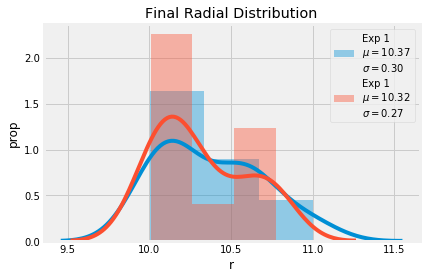

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

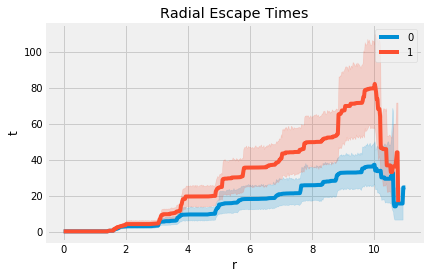

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

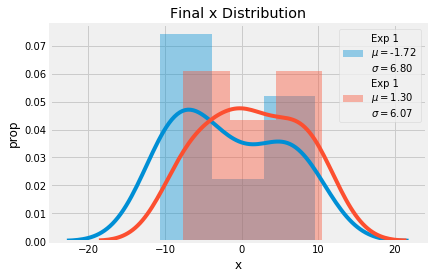

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

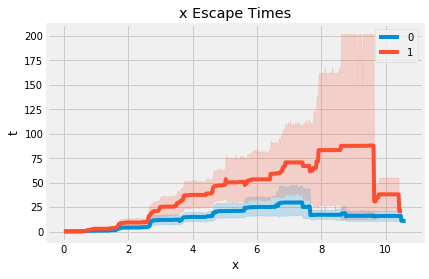

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

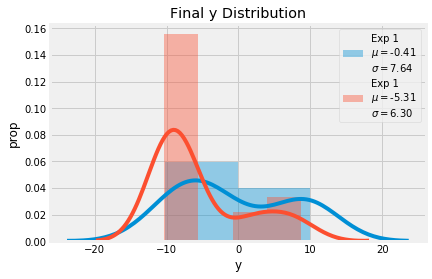

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

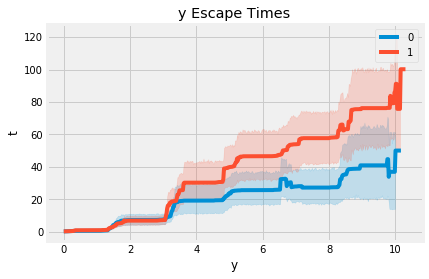

<IPython.core.display.Javascript object>



Experiment 0
{'a': 0.5,
 'b': 2.2,
 'bdy_radius': 10,
 'collision_law': 'wrap',
 'force': None,
 'gamma': 0.7071067811865475,
 'num_trials': 20,
 'scatterer_collision_law': 'specular',
 'sides': 6,
 'steps_max': 1000,
 'stuck': 0.0,
 'total': 20,
 'unused': 0,
 'used': 20}


Experiment 1
{'a': 0.5,
 'b': 2.2,
 'bdy_radius': 10,
 'collision_law': 'wrap',
 'force': None,
 'gamma': 0.7071067811865475,
 'num_trials': 20,
 'scatterer_collision_law': 'no_slip',
 'sides': 6,
 'steps_max': 1000,
 'stuck': 0.05,
 'total': 20,
 'unused': 1,
 'used': 19}


In [15]:
#@title Escape Time in Lorentz Gas with fixed boundary circle (double-click to open) { display-mode: "form" }

### List of values for important experimental parameters.  The function make_experiments will
### create the Cartesian product of the value lists to get all combinations
param_options = {}
param_options['a'] = 0.5
param_options['b'] = 2.2
param_options['gamma'] = 1/np.sqrt(2)
## Because force is a vector, it must be enclosed in double brackets ex: [[0.0,-1.0], [0.0,-3.0]]
param_options['force'] = None
param_options['collision_law'] = 'wrap'
param_options['scatterer_collision_law'] = ['specular', 'no_slip']
param_options['num_trials'] = 20
param_options['steps_max'] = 1000
param_options['sides'] = 6
param_options['bdy_radius'] = 10

experiments = make_experiments(param_options)    
run_path = base_path + timestamp() + "/"

for exp_idx, exp_params in enumerate(experiments):
    exp_path = run_path + f"{exp_idx}/"
    os.makedirs(exp_path, exist_ok=True)
    with open(exp_path+'params.json', 'w') as file:
        file.write(json.dumps(exp_params, cls=MyEncoder, separators=(', ',':')))

    for trial_idx in range(exp_params['num_trials']):
        trial_path = exp_path + f"{trial_idx}/"

        ### Setup Cell
        if exp_params['sides'] == 4:
            cell = SinaiCell(**exp_params, print_ignored=False)
        elif exp_params['sides'] == 6:
            cell = LorentzCell(**exp_params, print_ignored=False)
        else:
            raise Exception(f"Illegal number of sides = {exp_params[f'sides']}")
        Walls = cell.Walls

        ### Setup Particle
        part = Particle(**exp_params, print_ignored=False)
        try:
            part.radius = cell.particle_radius
        except:
            pass # uses default point particle
        
        ### Setup Stopping Conditions
        part.stopping_conditions.append(DistanceStoppingCondition(distance_max=exp_params['bdy_radius']))

        ### Setup Initial Conditions
        start_wall_idx = -1
        start_wall = Walls[start_wall_idx]
        part.wall_idx = start_wall.wall_idx

        p = start_wall.north
        p /= mag(p)
        w = (np.random.rand()*2-1) * np.pi
        p = p @ rotation_matrix(w)
        part.pos = start_wall.base + p * (start_wall.radius + part.radius)

        
        part.spin, vt, vn = draw_upper_hemisphere()
        vf = np.array([vn, vt])
        frame = -start_wall.get_frame(part)
        part.vel = vf @ frame

        part, Walls = run_trial(part, Walls)
        print(f"Ran trial {trial_idx} for {part.step} steps, final position = {part.pos+part.cell_shift}")

        part.run_path = run_path
        part.exp_path = exp_path
        part.trial_path = trial_path
        save_trial(part)

    ### Create and display output 
    ### Report display information about the experiment.  User may add or remove as they wish.
    report = deepcopy(exp_params)
    report['sides'] = exp_params['sides']
    report['scatterer_radius'] = cell.scatterer_radius
    report['particle_radius'] = cell.particle_radius
    pprint(report)

    
    ### Show image and animation from last trial of experiment 
    ax = draw(trial_path=trial_path, steps=100, show_arrows=True, show_trail=True, show_past=True)
    plt.show()

    anim = animate(trial_path=trial_path, movie_time=5, frames_per_second=50, smoothing=50,
                   save=True, embed=True, show_arrows=True, show_trail=True, show_past=True)
    

    ### arclength distribution
    draw_arclength_ecdf(trial_path=trial_path)
    plt.show()

    # ### phase portraits
    fig, ax = draw_phase_2d_3d(exp_path)
    plt.show()

summary_plots(run_path, use_complete=False, use_incomplete=True)

Ran trial 0 for 560 steps, final position = [  7.42264974 -10.69217173]
Ran trial 1 for 334 steps, final position = [ -8.57735026 -10.35665159]
Ran trial 2 for 66 steps, final position = [  4.34744013 -10.05458509]
Ran trial 3 for 1000 steps, final position = [ 3.02380612 -2.38497299]
Ran trial 4 for 311 steps, final position = [  0.36082188 -10.0689214 ]
Ran trial 5 for 706 steps, final position = [-19.42264974 -10.22564605]
Ran trial 6 for 268 steps, final position = [ -9.65417771 -10.05292862]
Ran trial 7 for 1000 steps, final position = [26.45885376 -3.0623543 ]
Ran trial 8 for 88 steps, final position = [ -3.53151486 -10.26864826]
Ran trial 9 for 629 steps, final position = [ -7.69881248 -10.0127586 ]
Ran trial 10 for 95 steps, final position = [  7.42264974 -10.40135098]
Ran trial 11 for 442 steps, final position = [  9.42264974 -10.08602662]
Ran trial 12 for 250 steps, final position = [  3.42264974 -10.21638987]
Ran trial 13 for 377 steps, final position = [ -4.57735026 -10.085

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in true_divide


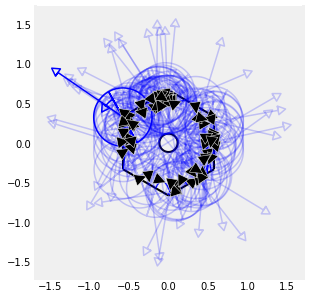

I will attempt to animate 250 frames


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in true_divide


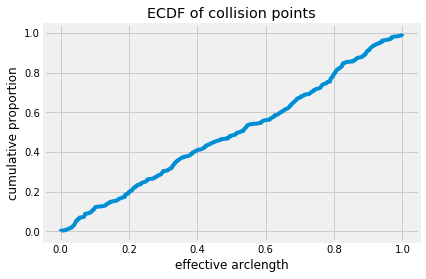

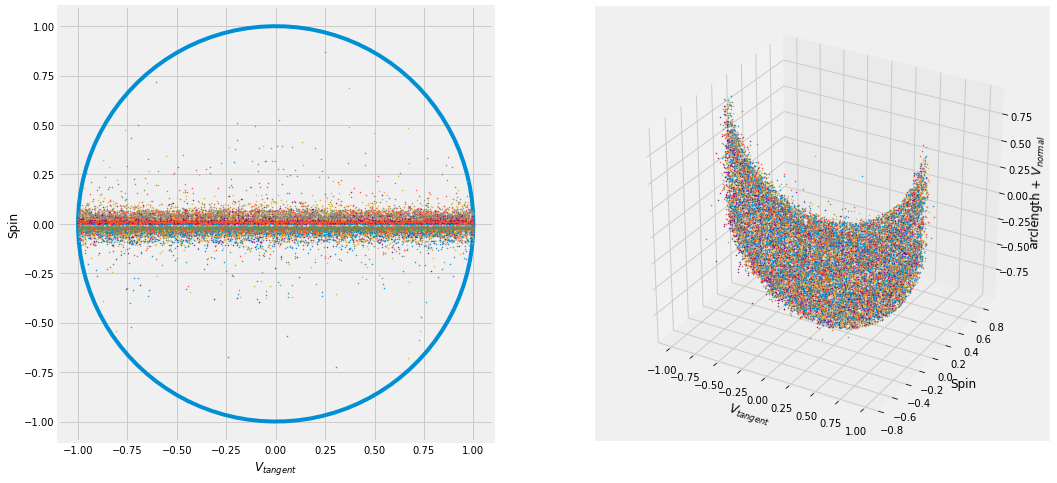

Ran trial 0 for 1000 steps, final position = [-1.68692088 -3.95001196]
Ran trial 1 for 600 steps, final position = [ -1.43868274 -10.04971486]
Ran trial 2 for 1000 steps, final position = [ 0.57735026 -3.18273313]
Ran trial 3 for 406 steps, final position = [  1.68016539 -10.02833356]
Ran trial 4 for 790 steps, final position = [ -3.67165582 -10.03599125]
Ran trial 5 for 1000 steps, final position = [ 4.42052619 -3.22342132]
Ran trial 6 for 910 steps, final position = [ -2.44460168 -10.19969481]
Ran trial 7 for 230 steps, final position = [ -0.57735026 -10.09594374]
Ran trial 8 for 1000 steps, final position = [ 5.78234877 -7.46920889]
Ran trial 9 for 354 steps, final position = [-11.71000072 -10.0041429 ]
Ran trial 10 for 1000 steps, final position = [ 4.25522252 -3.87596415]
Ran trial 11 for 1000 steps, final position = [19.46719626 -3.82315389]
Ran trial 12 for 995 steps, final position = [  9.42264974 -10.44385102]
Ran trial 13 for 817 steps, final position = [ -5.42264974 -10.2701

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in true_divide


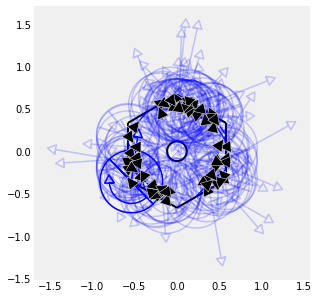

I will attempt to animate 250 frames


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in true_divide


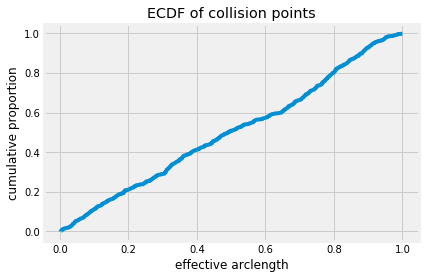

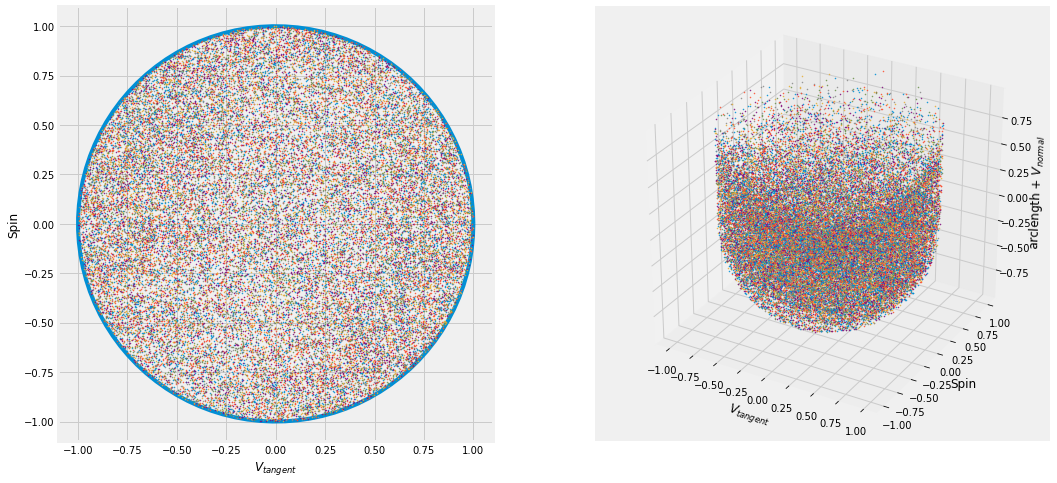



Experiment 0
{'a': 0.2,
 'b': 1.2,
 'collision_law': 'wrap',
 'force': [0.0, -2.0],
 'galton_levels': 10,
 'gamma': 0.7071067811865475,
 'num_trials': 50,
 'scatterer_collision_law': 'specular',
 'sides': 6,
 'steps_max': 1000}


Experiment 1
{'a': 0.2,
 'b': 1.2,
 'collision_law': 'wrap',
 'force': [0.0, -2.0],
 'galton_levels': 10,
 'gamma': 0.7071067811865475,
 'num_trials': 50,
 'scatterer_collision_law': 'no_slip',
 'sides': 6,
 'steps_max': 1000}


,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

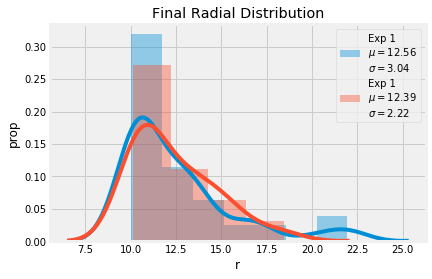

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

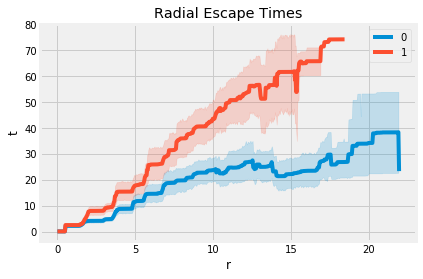

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

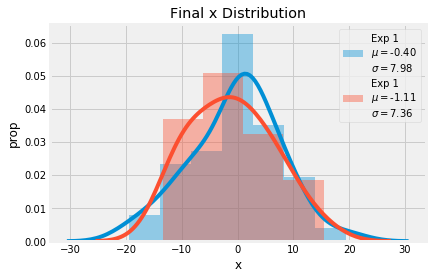

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

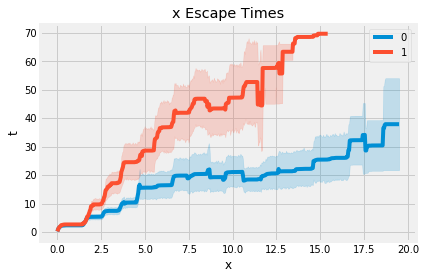

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

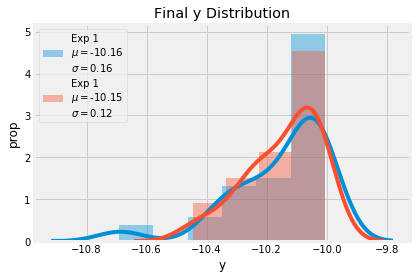

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

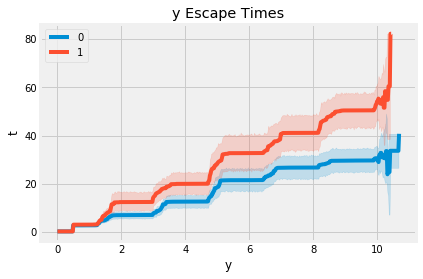

<IPython.core.display.Javascript object>

In [11]:
#@title Galton Board (double-click to open) { display-mode: "form" }

### List of values for important experimental parameters.  The function make_experiments will
### create the Cartesian product of the value lists to get all combinations
param_options = {}
param_options['a'] = 0.2
param_options['b'] = 1.2
param_options['gamma'] = 1/np.sqrt(2)
## Because force is a vector, it must be enclosed in double brackets ex: [[0.0,-1.0], [0.0,-3.0]]
param_options['force'] = [[0.0, -2.0]]  
param_options['collision_law'] = 'wrap'
param_options['scatterer_collision_law'] = ['specular', 'no_slip']
param_options['num_trials'] = 50
param_options['steps_max'] = 1000
param_options['sides'] = 6
param_options['galton_levels'] = 10

experiments = make_experiments(param_options)    
run_path = base_path + timestamp() + "/"

for exp_idx, exp_params in enumerate(experiments):
    exp_path = run_path + f"{exp_idx}/"
    os.makedirs(exp_path, exist_ok=True)
    with open(exp_path+'params.json', 'w') as file:
        file.write(json.dumps(exp_params, cls=MyEncoder, separators=(', ',':')))

    for trial_idx in range(exp_params['num_trials']):
        trial_path = exp_path + f"{trial_idx}/"

        ### Setup Cell
        if exp_params['sides'] == 4:
            cell = SinaiCell(**exp_params, print_ignored=False)
        elif exp_params['sides'] == 6:
            cell = LorentzCell(**exp_params, print_ignored=False)
        else:
            raise Exception(f"Illegal number of sides = {exp_params[f'sides']}")
        Walls = cell.Walls

        ### Setup Particle
        part = Particle(**exp_params, print_ignored=False)
        try:
            part.radius = cell.particle_radius
        except:
            pass # uses default point particle
        
        ### Setup Stopping Conditions
        # part.stopping_conditions.append(DistanceStoppingCondition(distance_max=exp_params['bdy_radius']))
        part.stopping_conditions.append(FloorStoppingCondition(floor=-1*exp_params['galton_levels']))

        ### Setup Initial Conditions
        start_wall_idx = -1
        start_wall = Walls[start_wall_idx]
        part.wall_idx = None

        part.pos = np.array([0.1 * draw_unif_signed(), 1.1]) * (part.radius + start_wall.radius)
        part.vel = np.array([0.0, 0.00])
        part.spin = 0.2 * draw_unif_signed()
        
        part, Walls = run_trial(part, Walls)
        print(f"Ran trial {trial_idx} for {part.step} steps, final position = {part.pos+part.cell_shift}")

        part.run_path = run_path
        part.exp_path = exp_path
        part.trial_path = trial_path
        save_trial(part)

    ### Create and display output 
    ### Report display information about the experiment.  User may add or remove as they wish.
    report = deepcopy(exp_params)
    report['sides'] = exp_params['sides']
    report['scatterer_radius'] = cell.scatterer_radius
    report['particle_radius'] = cell.particle_radius
    pprint(report)

    
    ### Show image and animation from last trial of experiment 
    ax = draw(trial_path=trial_path, steps=100, show_arrows=True, show_trail=True, show_past=True)
    plt.show()

    anim = animate(trial_path=trial_path, movie_time=5, frames_per_second=50, smoothing=50,
                   save=True, embed=True, show_arrows=True, show_trail=True, show_past=True)
    

    ### arclength distribution
    draw_arclength_ecdf(trial_path=trial_path)
    plt.show()

    # ### phase portraits
    fig, ax = draw_phase_2d_3d(exp_path)
    plt.show()

summary_plots(run_path, use_complete=False, use_incomplete=True)

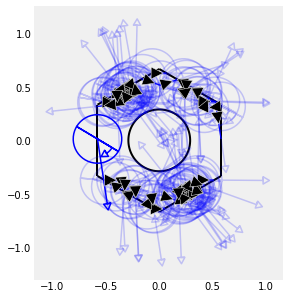

I will attempt to animate 250 frames


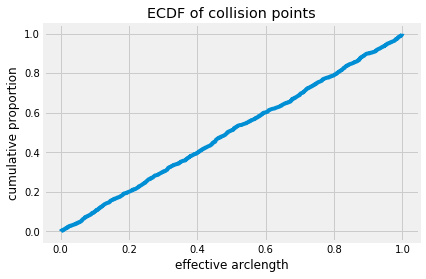

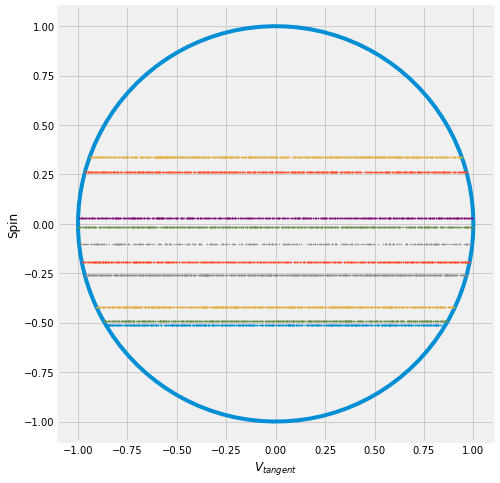

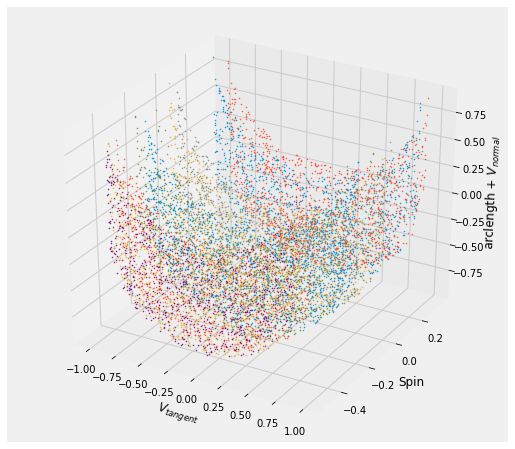

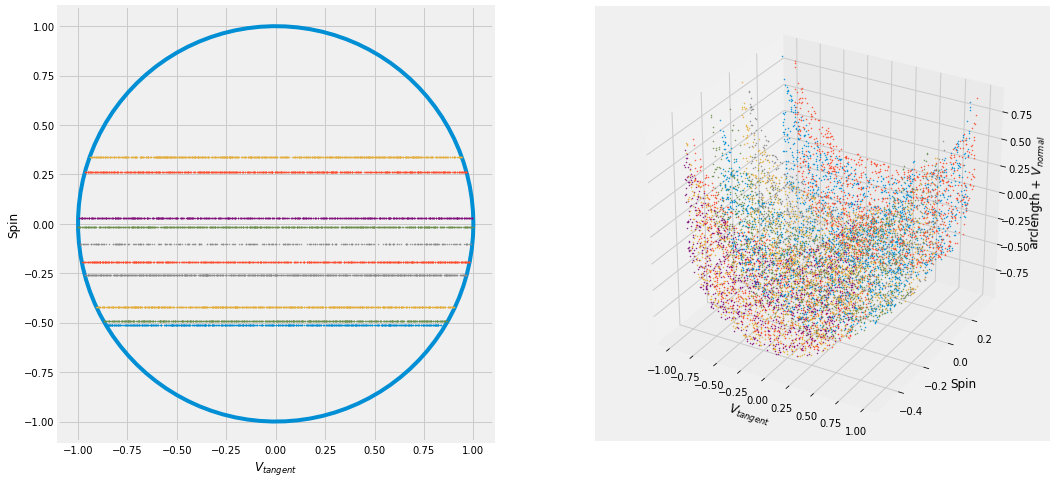

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: All-NaN slice encountered


9 of 10 = 90.00% trials did not escape


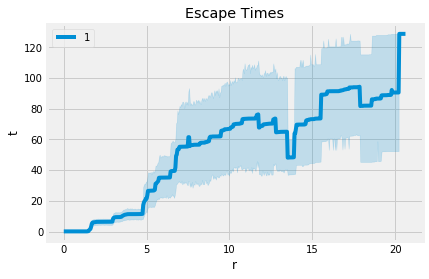

In [0]:
#@title Plotting from stored data (not at simulation time) (double-click to open) { display-mode: "form" }

run_path = '/content/2019-08-20_14-33-16/'
exp_path = run_path + "0/"
trial_path = exp_path + '0/'

## draw billiard trajectory
ax = draw(trial_path=trial_path, steps=100, show_arrows=True, show_trail=True, show_past=True)
plt.show()

## animate
anim = animate(trial_path=trial_path, movie_time=5, frames_per_second=50, smoothing=50,
               save=True, embed=True, show_arrows=True, show_trail=True, show_past=True)


## arclength distribution
draw_arclength_ecdf(trial_path=trial_path)
plt.show()

### phase portraits
ax = draw_phase_2d(exp_path)
plt.show()

ax = draw_phase_3d(exp_path)
plt.show()

ax2d, ax3d = draw_phase_2d_3d(exp_path)
plt.show()


### Escape time function
esc_times = get_escape_function(exp_path)
plt.show()
